In [1]:
# import pandas as pd

# df = pd.read_csv('Documents/projects/document-classifier/src/dataset/in_documents.pkl', sep='\t')
# df.columns = ["file_name", "list_keys", "pdf2djvu/djvu2hocr", "tesseract", "textract", "pdf2djvu/djvu2hocr_tesseract"]
# df = df.dropna(axis = 0)

In [2]:
# # Choose which extracted text method to use as input
# documents = df["tesseract"].tolist()
# df.head()

In [3]:
# # Treatment of cleaned text: tokenisation, stemming and lemmatisation
# import spacy
# from spacy.lang.en.stop_words import STOP_WORDS
# import string
# import pickle
# from rich.progress import track

# def cleaning(document):
#     # Load English tokenizer, tagger, parser and NER
#     nlp = spacy.load("en_core_web_sm")
#     # Process whole documents
#     document = document.replace("\\n"," ")
#     doc = nlp(document)

#     # Tokenisation
#     token_list = []
#     for token in doc:
#         token_list.append(token.text)

#     # Create list of word tokens after removing stopwords
#     filtered_sentence =[] 
#     nlp.Defaults.stop_words |= {'total', 'report', 'annual', 'period', 'date', 'para', 'statement', 'number', 'expenditure', 
#                        'director', 'result', 'financial', 'review', 'strategy', 'committee', 'executive', 'page',
#                        'trustee', 'charity', 'principal', 'signature', 'disclosure', 'performance', 'work',
#                        'association', 'trust', 'behalf', 'secretary', 'meeting', 'council', 'year', 'end', 'give',
#                        'content', 'message', 'chairman', 'chief', 'officer', 'audit', 'independent', 'charitable',
#                        'auditor', 'balance', 'budget', 'end', 'road', 'investment', 'fund', 'cash', 'examiner', 
#                        'january', 'february', 'march', 'april', 'may', 'june', 'july', 'asset',  'accounting',
#                        'general', 'account', 'name', 'unrestricted', 'accordance', 'continue', 'restrict',
#                        'cost', 'value', 'company', 'also', 'scheme', 'tot', 'provide',
#                        'august', 'september', 'october', 'november', 'december', 'income', 'fund', 'examination'}
#     for word in token_list:
#         lexeme = nlp.vocab[word]
#         if lexeme.is_stop == False:
#             filtered_sentence.append(word)
            
#     doc = nlp(' '.join(filtered_sentence))

#     #Lematization
#     lemma_word = [] 
#     for token in doc:
#         lemma_word.append(token.lemma_)

#     #Remove punctuation
#     doc = ' '.join(word.strip(string.punctuation) for word in lemma_word)
    
#     return doc

# Call of the function for all documents
# in_documents = [cleaning(document) for document in documents]

In [4]:
# import pickle
# with open('in_documents.pkl', 'wb') as f:
#     pickle.dump(in_documents, f)

In [5]:
# import pickle
# with open('../dataset/in_documents.pkl', 'rb') as f:
#     in_documents = pickle.load(f)

# text = in_documents[2].lower().split(' ')
# from collections import Counter
# word_counts = Counter(text)
# top_words = word_counts.most_common(100)
# print(top_words)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import pickle

with open('../dataset/in_documents.pkl', 'rb') as f:
    in_documents = pickle.load(f)

vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
trans = vectorizer.fit_transform(in_documents) # input must be a list of string aka whole text in one str

svd = TruncatedSVD(100)
X = svd.fit_transform(trans)

# Kmeans method
true_k = 6
model_k = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model_k.fit(X)

order_centroids = model_k.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()


In [ ]:
from fcmeans import FCM
# Soft clustering Method aka c-means clustering
model_c = FCM(n_clusters=6)
model_c.fit(X)

fcm_centers = model_c.centers
fcm_labels = model_c.predict(X)


In [14]:
with open('model_kmeans.pkl', 'wb') as f:
    pickle.dump(model_k, f)

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt
# Plot C-means
x = X[:,0]
y = X[:,1]
sns.scatterplot(x=x, y=y, hue=fcm_labels, palette='tab10')
# plot result
# f, axes = plt.subplots(1, 2, figsize=(11,5))
# axes[0].scatter(X[:,0], X[:,1], alpha=.1)
# axes[1].scatter(X[:,0], X[:,1], c=fcm_labels, alpha=.1)
# axes[1].scatter(fcm_centers[:,6], fcm_centers[:,6], marker="+", s=500, c='w')
# plt.show()

NameError: name 'fcm_labels' is not defined

<AxesSubplot:>

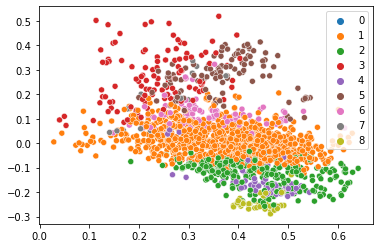

In [15]:
# Plot K-means
x = X[:,0]
y = X[:,1]
df = pd.DataFrame({'x': x,'y': y, 'model': model_k.labels_})

sns.scatterplot(x=x, y=y, hue=model_k.labels_, palette='tab10')

In [ ]:
import re
pat = r' \w '
string = 'This a is test u which is not a concluding'
x = re.findall(pat, string)
print(x)

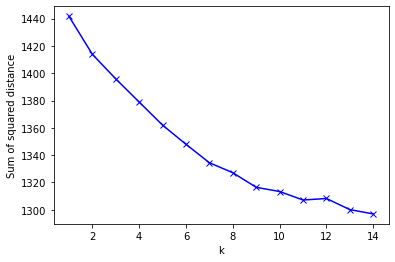

In [10]:
### Elbow method
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

inertia = []K = range(1,15)
for k in K:
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    model = model.fit(trans)
    inertia.append(model.inertia_)
### plot the inertia_
plt.plot(K, inertia, 'bx-')
plt.xlabel("k")
plt.ylabel("Sum of squared distance")
plt.show()

Cluster: 0


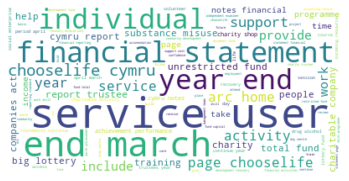

Cluster: 1


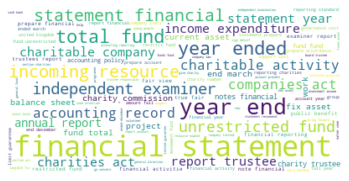

Cluster: 2


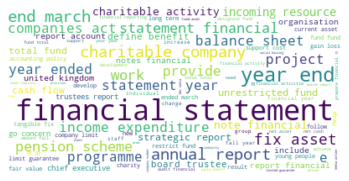

Cluster: 3


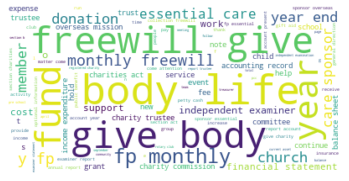

Cluster: 4


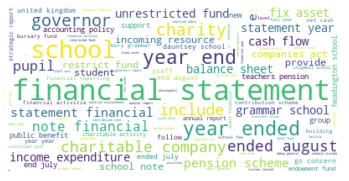

Cluster: 5


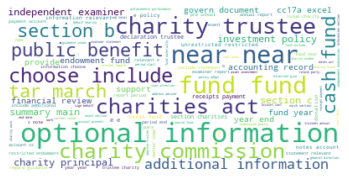

Cluster: 6


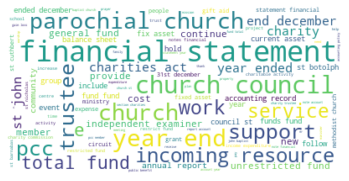

Cluster: 7


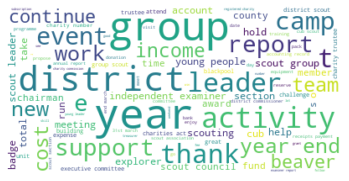

Cluster: 8


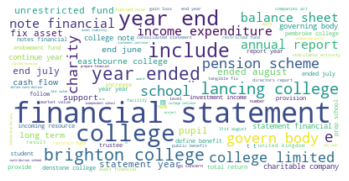

In [11]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

result={'cluster':model_k.labels_,'wiki':in_documents}
result=pd.DataFrame(result)
for k in range(0,true_k):
   s=result[result.cluster==k]
   text=s['wiki'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print(f'Cluster: {k}')
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

In [ ]:
import pdftotext

with open("dataset/testpdf.pdf", "rb") as f:
    pdf = pdftotext.PDF(f)

text = [" ".join([page for page in pdf])]
print(text)